In [71]:
import pandas as pd
import numpy as np
import collections
import datetime
import time
from github import Github, RateLimitExceededException
import os
import itertools
import seaborn as sns
import io
from dotenv import load_dotenv, find_dotenv
import boto3

In [16]:
load_dotenv(find_dotenv())

True

In [17]:
g = Github(os.getenv("GITHUB_ACCESS_TOKEN"))

In [18]:
name = os.getenv("REPO_NAME")

if "/" in name:
    REPO = name
    USER = ""
else:
    USER = name
    REPO = ""

In [19]:
# whether to use ceph or store locally

use_ceph = True

if use_ceph:
    s3_endpoint_url = os.environ["OBJECT_STORAGE_ENDPOINT_URL"]
    s3_access_key = os.environ["AWS_ACCESS_KEY_ID"]
    s3_secret_key = os.environ["AWS_SECRET_ACCESS_KEY"]
    s3_bucket = os.environ["OBJECT_STORAGE_BUCKET_NAME"]

    s3 = boto3.client(
        service_name="s3",
        aws_access_key_id=s3_access_key,
        aws_secret_access_key=s3_secret_key,
        endpoint_url=s3_endpoint_url,
    )

In [20]:
# add all repos to list, or create list of one
repos_ = []

if USER:
    org = g.get_user(USER)
    repos = org.get_repos()
    for repo in repos:
        repos_.append(repo)
else:
    to_add = g.get_repo(REPO)
    repos_.append(to_add)

In [29]:
# load dataframe if exists

savename = USER if USER else REPO.replace("/", "-_-")

if use_ceph:
    try:
        key = f"github-labeler/data/{savename}.csv"
        response = s3.get_object(Bucket=s3_bucket, Key=key)
        existing_df = pd.read_csv(response.get("Body")).drop_duplicates()
    except s3.exceptions.NoSuchKey:
        existing_df = None
else:
    if os.path.exists(f"../../data/{savename}.csv"):
        existing_df = pd.read_csv(f"../../data/{savename}.csv")
    else:
        existing_df = None

In [65]:
def get_issues_for_repo(repo, last_issue=None):
    """
    takes in a pygithub repo object and returns the list of pygithub issue objects
    """
    issues = []
    issues_left = True
    max_date = last_issue if last_issue is not None else datetime.datetime.min
    while issues_left:
        issues_left = False
        try:
            for issue in repo.get_issues(state="all", direction="asc", since=max_date):
                if issue.created_at <= max_date:
                    continue
                max_date = issue.created_at
                if issue.pull_request is None:
                    issues.append(issue)
        except RateLimitExceededException:
            # rate limit exception
            print(len(issues), "issues added for", {repo.full_name})
            print("SLEEPING NOW FOR AN HOUR")
            time.sleep(60 * 61)
            issues_left = True
    return issues

In [66]:
# add in all issues
all_issues = {}

if existing_df is not None:
    last_date = datetime.datetime.fromisoformat(existing_df.created_at.max())
else:
    last_date = None

if USER:
    print("getting issues for repos")
    for repo in repos_:
        all_issues[repo.full_name] = get_issues_for_repo(repo, last_date)
else:
    repo = repos_[0]
    all_issues[repo.full_name] = get_issues_for_repo(repo, last_date)

total_issues = sum([len(b) for a, b in all_issues.items()])
print(total_issues, "total issues")

2 total issues


In [70]:
# create a dataframe for issues

issue_data = []

for repo, issues in all_issues.items():
    for issue in issues:
        labels = [lbl.name for lbl in issue.labels]
        label_names = "\t".join(labels) if labels else np.nan
        id_ = repo + "/" + str(issue.number)
        data = [
            id_,
            repo,
            issue.title,
            issue.body,
            issue.created_at,
            issue.user.login,
            len(labels),
            label_names,
        ]
        issue_data.append(data)
cols = [
    "id",
    "repo",
    "title",
    "body",
    "created_at",
    "created_by",
    "num_labels",
    "labels",
]

if existing_df is not None:
    issues_df = pd.concat([existing_df, pd.DataFrame(issue_data, columns=cols)])

else:
    issues_df = pd.DataFrame(issue_data, columns=cols)

In [72]:
# show issues dataframe
issues_df.sample(5)

,id,repo,title,body,created_at,created_by,num_labels,labels
8145,openshift/origin/17781,openshift/origin,TestProjectRequestError,https://openshift-gce-devel.appspot.com/build/...,2017-12-14 13:22:07,kargakis,3,priority/P2\tarea/tests\tsig/master
4337,openshift/origin/11161,openshift/origin,"Make verify fails with ""Swagger spec out of date""",Jenkins (and Travis) tests keep failing with `...,2016-09-29 17:08:53,juanvallejo,1,kind/test-flake
5693,openshift/origin/11859,openshift/origin,oc cluster up fails to install metrics,There has been a change in origin metrics wher...,2016-11-09 21:55:02,mwringe,4,area/usability\tpriority/P2\tcomponent/composi...
3683,openshift/origin/9434,openshift/origin,Update custom errors for deployment controller...,@deads2k @mfojtik \n,2016-06-20 12:45:10,kargakis,4,priority/P3\tcomponent/apps\thelp wanted\tlife...
4288,openshift/origin/11042,openshift/origin,Source pod ip is not preserved when contacting...,A kube e2e test was added to validate preserva...,2016-09-21 15:08:47,marun,4,priority/P3\tcomponent/networking\tarea/techde...


In [11]:
# view most common labels

label_lst = list(
    itertools.chain.from_iterable([ls.split("\t") for ls in issues_df.labels.dropna()])
)
counter = collections.Counter(label_lst)

counter.most_common(20)

[('question', 1178),
 ('needs triage', 987),
 ('stale', 463),
 ('bug', 401),
 ('enhancement', 167),
 ('help wanted', 146),
 ('documentation', 85),
 ('speech-to-text', 42),
 ('windows', 26),
 ('unable to repro', 26),
 ('wav2vec', 9),
 ('BART/mBART', 4),
 ('cleanup', 3),
 ('0.10.2', 2),
 ('M2M-100', 2),
 ('LayerDrop', 1),
 ('python3.9', 1),
 ('translation', 1),
 ('paraphraser', 1),
 ('DynamicConv/LightConv', 1)]

In [12]:
# view most common issue creators

issues_df.created_by.value_counts()[:20]

shamanez          31
erip              27
gaopengcuhk       20
ajesujoba         20
astariul          18
nicolabertoldi    17
travel-go         16
tuhinjubcse       16
munael            16
gvskalyan         15
villmow           15
MrityunjoyS       14
getao             14
aastha19          13
haorannlp         13
ghost             13
14H034160212      13
ismymajia         12
louismartin       11
sshleifer         11
Name: created_by, dtype: int64

(0.0, 6.0)

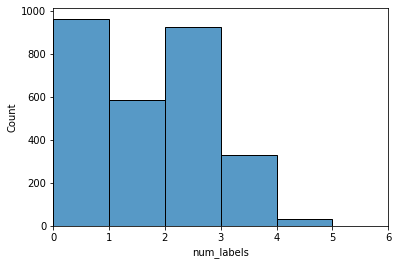

In [13]:
# view distribution of the number of issues in a label

ax = sns.histplot(issues_df.num_labels, bins=int(max(issues_df.num_labels)))
ax.set_xlim((0, 6))

In [14]:
# save dataframe
savename = USER if USER else REPO.replace("/", "-_-")

if use_ceph:
    with io.StringIO() as csv_buffer:
        issues_df.to_csv(csv_buffer, index=False)

        response = s3.put_object(
            Bucket=s3_bucket,
            Key=f"github-labeler/data/{savename}.csv",
            Body=csv_buffer.getvalue(),
        )
else:
    issues_df.to_csv(os.path.join("../../data", savename + ".csv"), index=None)